# Description

This notebook first calculates the Bayesian posterior distribution of the Poisson event occurrence rate, given the number of observed events ```n_events_A``` during a test duration ```test_duration_A``` in a first experiment (A), using a uniform prior distribution. It then calculates the distribution of observed events in a second experiment (B) of duration ```test_duration_B``` by using a Poisson conditional distribution and the previously calculated distribution for the event occurrence rate to calculate the marginal distribution for the number of observed events in the second experiment (B).

This notebook tells you how many events to expect from a test of duration ```test_duration_B``` if you had previously conducted a test of the same system of duration ```test_duration_A``` during which you got ```n_events_A``` events. It does so by first calculating a distribution for the possible event occurrence rates your system might possess from the result of your experiment (A), and them using that information to calculate the probabilities for the possible outcomes of your test (B). This result depends on a so-called prior distribution that models your belief in different possible event occurrence rates before test (A). By default we choose a uniform prior, since this does not skew the results (the maximum belief will be for exactly the success rate of your test run).

__Note__
1. All probabilities are given as numbers between 0 and 1, where 0 represents "never" and 1 represents 100% certainty.
2. The calculated degree of belief is __NOT__ conservative. It depends on the chosen prior and can be both too high and too low.

# Parameters

In [1]:
test_duration_A = 10
n_events_A = 1

test_duration_B = 10

assert isinstance(test_duration_A, (int, float)) and test_duration_A > 0
assert isinstance(test_duration_B, (int, float)) and test_duration_B > 0
assert isinstance(n_events_A, int) and n_events_A >= 0

# Evaluation

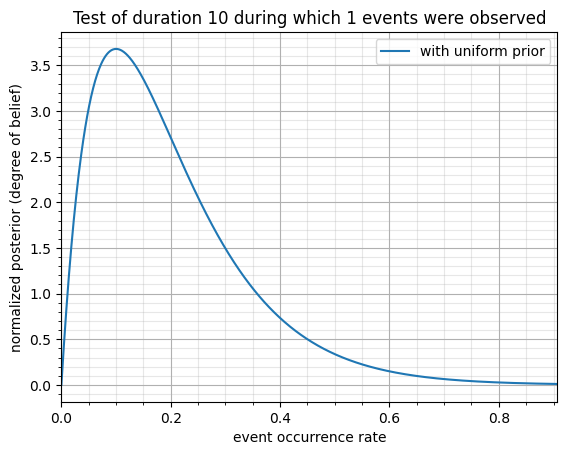

In [2]:
import matplotlib.pyplot as plt
import mpmath as mp
import numpy as np
from scipy import integrate

mp.mp.dps = 50 #use 50 decimal digits precision in mpmath calculations

#posterior is unnormalized to save calculation time, remember to normalize result when needed
def posterior_prob_poisson_r(r_event, test_duration_A, n_events_A, prior):
    return mp.power(mp.mpf(r_event*test_duration_A), n_events_A) / mp.fac(n_events_A) * mp.exp(-r_event*test_duration_A) * prior(r_event, test_duration_A)

posterior_prob_poisson_r_vectorized = np.vectorize(posterior_prob_poisson_r)

#split the integral into constant and non-constant parts and prescale so numerical integration does not fail due to sharp peak for large test_duration
def integrate_posterior_prob_poisson_r(test_duration_A, n_events_A, prior, bounds):
    mean = (n_events_A+1) / test_duration_A
    std_dev = (n_events_A+1)**0.5 / test_duration_A
    prescale = 1/posterior_prob_poisson_r(mean, test_duration_A, n_events_A, prior)
    prior_prescaled = lambda r, duration: prior(r, duration) * prescale
    
    norm = 0
    if bounds[0] < mean-3*std_dev:
        norm += integrate.quad(posterior_prob_poisson_r, max(0, bounds[0]), min(mean-3*std_dev, bounds[1]), args=(test_duration_A, n_events_A, prior_prescaled))[0]
    if bounds[0] < mean and bounds[1] >= mean-3*std_dev:
        norm += integrate.quad(posterior_prob_poisson_r, max(mean-3*std_dev, bounds[0]), min(mean, bounds[1]), args=(test_duration_A, n_events_A, prior_prescaled))[0]
    if bounds[0] < mean+3*std_dev and bounds[1] >= mean:
        norm += integrate.quad(posterior_prob_poisson_r, max(mean, bounds[0]), min(mean+3*std_dev, bounds[1]), args=(test_duration_A, n_events_A, prior_prescaled))[0]
    if bounds[0] < 1 and bounds[1] >= mean+3*std_dev:
        norm += integrate.quad(posterior_prob_poisson_r, max(mean+3*std_dev, bounds[0]), bounds[1], args=(test_duration_A, n_events_A, prior_prescaled))[0]
        
    return norm / prescale

r_plotmax = (n_events_A+1)/test_duration_A + 5*(n_events_A+1)**0.5/test_duration_A #mean+5*std_dev
r = np.linspace(0, r_plotmax, 1001)

prior = lambda rate, duration: 1
norm_posterior = integrate_posterior_prob_poisson_r(test_duration_A, n_events_A, prior, [0, np.inf])
posterior_probs = posterior_prob_poisson_r_vectorized(r, test_duration_A, n_events_A, prior) / norm_posterior
plt.plot(r, posterior_probs, label='with uniform prior')

# r = r[r > 0] #Exclude singularity at 0 of Jeffrey's prior
# prior = lambda rate, duration: (rate*duration)**-0.5
# prior_vectorized = np.vectorize(prior)
# norm_posterior = integrate_posterior_prob_poisson_r(test_duration_A, n_events_A, prior, [0, np.inf])
# posterior_probs = posterior_prob_poisson_r_vectorized(r, test_duration_A, n_events_A, prior) / norm_posterior
# plt.plot(r, posterior_probs, label='with Jeffrey\'s prior')
# plt.plot(r, prior_vectorized(r, test_duration_A), label='Jeffrey\'s prior')

plt.gca().set_title('Test of duration {} during which {} events were observed'.format(test_duration_A, n_events_A))
plt.gca().set_xlabel('event occurrence rate')
plt.gca().set_ylabel('normalized posterior (degree of belief)')
plt.gca().tick_params(axis='x', which='minor', bottom=True)
plt.gca().minorticks_on()
plt.grid(which='major')
plt.grid(which='minor', alpha=0.3);
plt.legend()

plt.gca().set_xlim([0, r_plotmax]); #change plot range here

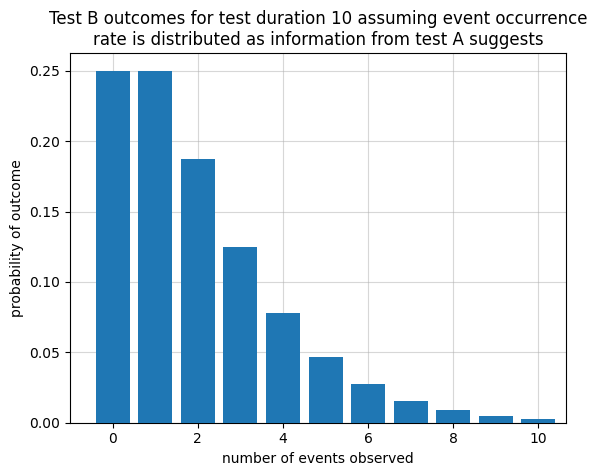

In [3]:
def conditional_distr(n_events, r_event, test_duration):
    return mp.power(mp.mpf(r_event*test_duration), n_events) / mp.fac(n_events) * mp.exp(-r_event*test_duration)

conditional_distr_vectorized = np.vectorize(conditional_distr) #create version of poisson distribution that can be evaluated for whole lists of inputs

def marginal_distr(n_events_B, test_duration_B, test_duration_A, n_events_A, prior, norm_posterior):
    mean = (n_events_A+1) / test_duration_A
    std_dev = (n_events_A+1)**0.5 / test_duration_A
    prescale = 1/posterior_prob_poisson_r(mean, test_duration_A, n_events_A, prior)
    prior_prescaled = lambda r, duration: prior(r, duration) * prescale

    integrand = lambda r: posterior_prob_poisson_r(r, test_duration_A, n_events_A, prior_prescaled) * conditional_distr(n_events_B, r, test_duration_B)
    bounds = [0, 1]
    
    int_value = 0
    if bounds[0] < mean-3*std_dev:
        int_value += integrate.quad(integrand, max(0, bounds[0]), min(mean-3*std_dev, bounds[1]))[0]
    if bounds[0] < mean and bounds[1] >= mean-3*std_dev:
        int_value += integrate.quad(integrand, max(mean-3*std_dev, bounds[0]), min(mean, bounds[1]))[0]
    if bounds[0] < mean+3*std_dev and bounds[1] >= mean:
        int_value += integrate.quad(integrand, max(mean, bounds[0]), min(mean+3*std_dev, bounds[1]))[0]
    if bounds[0] < 1 and bounds[1] >= mean+3*std_dev:
        int_value += integrate.quad(integrand, max(mean+3*std_dev, bounds[0]), min(1, bounds[1]))[0]
        
    return int_value / prescale / norm_posterior

marginal_distr_vectorized = np.vectorize(marginal_distr)

r_mean = (n_events_A+1) / test_duration_A
r_std_dev = (n_events_A+1)**0.5 / test_duration_A
r_plotmax = (r_mean + 2*r_std_dev) * test_duration_B * 2 #change plot range here

x = np.arange(0, r_plotmax+1) #list of all possible outcomes (number of events observed x during test_duration)
P_x = marginal_distr_vectorized(x, test_duration_B, test_duration_A, n_events_A, prior, norm_posterior) #probabilities of each of these outcomes

#plot
plt.bar(x, P_x, zorder=3)

plt.gca().set_title('Test B outcomes for test duration {} assuming event occurrence\nrate is distributed as information from test A suggests'.format(test_duration_B))
plt.gca().set_xlabel('number of events observed')
plt.gca().set_ylabel('probability of outcome')
plt.grid(alpha=0.5)

plt.gca().set_xlim([-1, r_plotmax+1]);